## 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import random
import requests

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt 
%matplotlib inline 
from IPython.display import Image 
from IPython.core.display import HTML

from geopy.geocoders import Nominatim
import folium

from pandas.io.json import json_normalize

from sklearn.cluster import KMeans 

## 2. Importing dataset containing food outlets in Pune on Zomato

In [2]:
columns=['Restaurant_Name','Locality','Ratings_out_of_5','Number of votes','Detail_address']
#usecols=columns
df = pd.read_csv('zomato_pune_v002.csv',usecols=columns)
df.head()

,Restaurant_Name,Locality,Ratings_out_of_5,Number of votes,Detail_address
0,AB's - Absolute Barbecues,Hinjawadi,4.9,7029 votes,"Shop 206, 2nd Floor, White Square Building, Op..."
1,Cafe Co2 Resto Lounge,Bhugaon,4.6,2578 votes,"Near Manas Lake, Bhugaon, Pune"
2,Paasha - JW Marriott Pune,Senapati Bapat Road,4.6,3291 votes,"JW Marriott, Senapati Bapat Road, Pune"
3,I Amsterdam,Hinjawadi,4.3,430 votes,"Survey 257/1/1A, Near Raj Laxmi Petrol Pump, P..."
4,FC Road Social,Shivaji Nagar,4.5,2138 votes,"CTS 1183, Unit 101, 1st Floor, Mezzanine Floor..."


In [3]:
# Stripping votes to numbers only
df['Number of votes'] = df['Number of votes'].map(lambda x: x.rstrip(' votes').lstrip('Based on '))

In [4]:
# Changing dtypes to numeric
df['Number of votes']=pd.to_numeric(df['Number of votes'], errors='coerce')
df['Ratings_out_of_5']=pd.to_numeric(df['Ratings_out_of_5'],errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12189 entries, 0 to 12188
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Restaurant_Name   12189 non-null  object 
 1   Locality          12189 non-null  object 
 2   Ratings_out_of_5  8920 non-null   float64
 3   Number of votes   12183 non-null  float64
 4   Detail_address    12189 non-null  object 
dtypes: float64(2), object(3)
memory usage: 476.3+ KB


## 3. Creating dataset of Pune localities with coordinates

In [5]:
locality = pd.DataFrame({'Locality':df['Locality'].unique()})

In [6]:
# Getting coordinates from Nominatim

from geopy.geocoders import Nominatim    
from geopy.extra.rate_limiter import RateLimiter


geolocator = Nominatim(user_agent='myGeocoder',timeout=None)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

locality['location'] = locality['Locality'].apply(geocode)
locality['Coordinates'] = locality['location'].apply(lambda loc: tuple(loc.point) if loc else None)
locality.drop('location',axis=1,inplace=True)

In [7]:
locality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Locality     99 non-null     object
 1   Coordinates  92 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


In [8]:
# Coordinates to separate columns of lat, long
locality[['Latitude', 'Longitude','extra']] = pd.DataFrame(locality['Coordinates'].tolist(), index=locality.index)
locality.drop(['Coordinates','extra'], axis=1, inplace=True)

# Dropping rows with any null value
locality.dropna(how='any', inplace=True)
locality.reset_index(drop=True,inplace=True)

In [9]:
locality.head()

,Locality,Latitude,Longitude
0,Hinjawadi,18.594063,73.742049
1,Bhugaon,20.951377,79.937120
2,Senapati Bapat Road,18.525574,73.829548
3,Shivaji Nagar,25.884554,86.039850
4,Wakad,18.610902,73.763796


## 4. Getting information on cafes in above localities from FourSquare using API

In [10]:
CLIENT_ID = 'my_client_id'
CLIENT_SECRET = 'my_client_secret'
VERSION = '20200604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EOPLXVXNFAJFOTACN4IMEO2LVNXAIXXIPUMKOUNLUJEC22VL
CLIENT_SECRET:WBHZIR2SG4U0L4B1Y2DK0FLIXAQ45AYJN0SAD1H3M2ENPKCJ


In [11]:
## create a function to repeat the same process of searching Cafes in all Localities of Pune

def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT = 100):
    
    search_query = 'Cafe'    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
            
        venues = requests.get(url).json()["response"]['venues']
        #dataframe = json_normalize(results)
        
        # getting only relevant information for each nearby venue
        venues_list.append([(
                name, 
                lat,
                lng,
                v['name'], 
                v['location']['lat'], 
                v['location']['lng']) for v in venues])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Locality', 
                             'Locality Latitude',
                             'Locality Longitude',
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude']
    
    return(nearby_venues)

In [12]:
# find the cafes in all Pune
pune_cafes = getNearbyVenues(
    names=locality['Locality'],
    latitudes=locality['Latitude'],
    longitudes=locality['Longitude'])

In [13]:
pune_cafes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Locality            345 non-null    object 
 1   Locality Latitude   345 non-null    float64
 2   Locality Longitude  345 non-null    float64
 3   Venue               345 non-null    object 
 4   Venue Latitude      345 non-null    float64
 5   Venue Longitude     345 non-null    float64
dtypes: float64(4), object(2)
memory usage: 16.3+ KB


In [14]:
import gc
gc.collect()

40

## 5. Merging zomato and FourSquare datasets

In [15]:
full = pune_cafes.merge(df,how='left',left_on='Venue', right_on='Restaurant_Name')

In [16]:
full.dropna(inplace=True)
full.reset_index(drop=True)

,Locality_x,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Restaurant_Name,Locality_y,Ratings_out_of_5,Number of votes,Detail_address
0,Senapati Bapat Road,18.525574,73.829548,Pune Egg Cafe,18.521736,73.829345,Pune Egg Cafe,Wakad,3.8,36.0,"Shop 9, Windsor Appartment, Mauli Chowk, Wakad..."
1,Senapati Bapat Road,18.525574,73.829548,Sugardough,18.529989,73.832478,Sugardough,Kothrud,4.0,112.0,"Shop 6, Aishwarya Complex, Mayur Colony, Kothr..."
2,Yerawada,18.565632,73.886576,Cafe Coffee Day,18.563955,73.884073,Cafe Coffee Day,MG Road,3.6,52.0,"Shop 328, Sachapir Street, MG Road, Pune"
3,Bavdhan,18.520954,73.778087,The Classroom Cafe,18.520205,73.778464,The Classroom Cafe,Bavdhan,3.7,58.0,"Shop L2, Navkar Avenue, Behind Axis Bank, NDA ..."
4,Bavdhan,18.520954,73.778087,The Fat Labrador Cafe,18.520631,73.776067,The Fat Labrador Cafe,Bavdhan,4.1,136.0,"Shop 4 A, Business Square, Opposite DSK Ranwar..."
...,...,...,...,...,...,...,...,...,...,...,...
102,Lavasa,18.403222,73.506771,Cafe Coffee Day,18.406508,73.505642,Cafe Coffee Day,MG Road,3.6,52.0,"Shop 328, Sachapir Street, MG Road, Pune"
103,Around Pune,18.553316,73.807092,Cafe Old Skool,18.553480,73.807578,Cafe Old Skool,Viman Nagar,3.5,18.0,"Shop 2, Konark Epitome, Premises Cooperative H..."
104,Around Pune,18.553316,73.807092,Cafe Chokolade,18.554037,73.804876,Cafe Chokolade,Wanowrie,3.5,53.0,"9, Regency Arcade, Green Valley, Wanowrie, Pune"
105,Around Pune,18.553316,73.807092,Cafe Roberto,18.553534,73.802677,Cafe Roberto,Baner,4.2,209.0,"Bhagyashree Building, Baner, Pune"


In [17]:
# Cleaning data
pd.set_option('max_rows',None)
dropped = full[['Venue','Venue Latitude','Venue Longitude','Locality_y','Ratings_out_of_5','Number of votes']]
grouped=dropped.groupby(['Venue','Venue Latitude','Venue Longitude']).agg(np.mean)
grouped

Ratings_out_of_5  \
Venue                   Venue Latitude Venue Longitude                     
Cafe Boulevard          18.534728      73.876234                   3.300   
Cafe Choco Craze        18.507970      73.850350                   3.650   
Cafe Chokolade          18.488636      73.899151                   3.500   
                        18.516858      73.841628                   3.500   
                        18.548301      73.905931                   3.500   
                        18.554037      73.804876                   3.500   
Cafe Coffee Day         17.430436      78.439536                   3.600   
                        17.432237      78.439599                   3.600   
                        17.443324      78.480302                   3.600   
                        18.406508      73.505642                   3.600   
                        18.479538      73.896323                   3.600   
                        18.481001      73.862980                   3.600   
                        18.481723      73.898195                   3.600   
                        18.502777      73.900785                   3.600   
                        18.506597      73.850536                   3.600   
                        18.521771      73.876355                   3.600   
                        18.522245      73.840968                   3.600   
                        18.525054      73.841514                   3.600   
                        18.531384      73.876113                   3.600   
                        18.534203      73.876430                   3.600   
                        18.545839      73.906457                   3.600   
                        18.550627      73.901024                   3.600   
                        18.563955      73.884073                   3.600   
                        18.627325      73.804166                   3.600   
Cafe Colombia           18.549286      73.903285                   4.000   
Cafe Cool               18.512372      73.846389                   3.500   
                        18.642405      73.795929                   3.500   
Cafe Creme              18.456848      73.854965                   1.625   
                        18.513264      73.846412                   1.625   
                        18.532715      73.833946                   1.625   
Cafe Deccan             18.513964      73.841255                   3.500   
Cafe Du-Mich            18.533745      73.920456                   4.000   
Cafe Durga              18.508266      73.850329                   2.350   
                        18.513200      73.836849                   2.350   
                        18.529933      73.836857                   2.350   
Cafe India              18.478713      73.896578                   4.200   
Cafe Little Eggs        18.535306      73.880189                   3.300   
Cafe London Dreams      18.537682      73.898705                   4.000   
Cafe Old Skool          18.553480      73.807578                   3.500   
Cafe Roberto            18.553534      73.802677                   2.100   
Cafe Zam Zam            18.472494      73.891489                   3.800   
Cake N Cafe             18.512350      73.846194                   3.500   
                        18.512758      73.839004                   3.500   
Cheese Omelette Cafe    18.549227      73.918784                   3.500   
De' Kettle Cafe         18.479872      73.901579                   3.700   
Dharwad Cafe            18.518188      73.837701                   3.100   
Fat Cat's Cafe          18.481174      73.904939                   4.100   
Irani Cafe              18.514174      73.837650                   0.000   
                        18.547316      73.900320                   0.000   
J M Cafe                18.485646      73.898854                   3.200   
Kerala Cafe             18.549197      73.902416                   4.400   
Laddro Cafe             18.5

In [18]:
grouped.reset_index(inplace=True)
grouped

,Venue,Venue Latitude,Venue Longitude,Ratings_out_of_5,Number of votes
0,Cafe Boulevard,18.534728,73.876234,3.300,11.00
1,Cafe Choco Craze,18.507970,73.850350,3.650,91.50
2,Cafe Chokolade,18.488636,73.899151,3.500,53.00
3,Cafe Chokolade,18.516858,73.841628,3.500,53.00
4,Cafe Chokolade,18.548301,73.905931,3.500,53.00
5,Cafe Chokolade,18.554037,73.804876,3.500,53.00
6,Cafe Coffee Day,17.430436,78.439536,3.600,52.00
7,Cafe Coffee Day,17.432237,78.439599,3.600,52.00
8,Cafe Coffee Day,17.443324,78.480302,3.600,52.00
9,Cafe Coffee Day,18.406508,73.505642,3.600,52.00


## 6. Visualizaing all cafes on map using folium

In [19]:
from IPython.display import display
latitude=18.5204
longitude=73.8567
venues_map = folium.Map(location=[latitude, longitude], zoom_start=10)


# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='black',
    popup='Pune',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(grouped['Venue Latitude'], grouped['Venue Longitude'], grouped['Venue']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
display(venues_map)

array([[<AxesSubplot:title={'center':'Ratings_out_of_5'}>,
        <AxesSubplot:title={'center':'Number of votes'}>]], dtype=object)

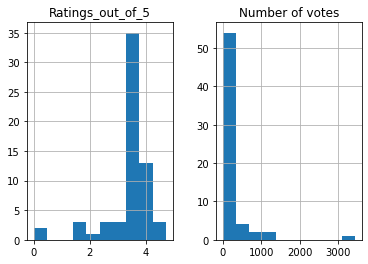

In [20]:
grouped[['Ratings_out_of_5','Number of votes']].hist(bins=10)

## 7. Applying K-Means Clustering

In [21]:
df2 = grouped.drop(['Venue','Ratings_out_of_5','Number of votes'], axis=1)
df2.head()

,Venue Latitude,Venue Longitude
0,18.534728,73.876234
1,18.507970,73.850350
2,18.488636,73.899151
3,18.516858,73.841628
4,18.548301,73.905931


**Now let's normalize the dataset. We will use StandardScaler() to normalize our dataset.**


In [22]:
from sklearn.preprocessing import StandardScaler

X = df2.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.24063617],
       [-0.26370843],
       [-0.2202087 ],
       [-0.27148318],
       [-0.21416546],
       [-0.30424276],
       [ 3.82696776],
       [ 3.82702375],
       [ 3.86330569],
       [-0.57097192],
       [-0.22272914],
       [-0.25245015],
       [-0.22106102],
       [-0.2187521 ],
       [-0.2635428 ],
       [-0.24052868],
       [-0.27207151],
       [-0.27158487],
       [-0.24074366],
       [-0.24046143],
       [-0.2136961 ],
       [-0.21853912],
       [-0.23364848],
       [-0.3048753 ],
       [-0.21652396],
       [-0.26723921],
       [-0.31221811],
       [-0.25959456],
       [-0.26721874],
       [-0.27833052],
       [-0.27181547],
       [-0.20121784],
       [-0.2637274 ],
       [-0.2757426 ],
       [-0.27573548],
       [-0.22250214],
       [-0.23711076],
       [-0.2206061 ],
       [-0.3018339 ],
       [-0.30620286],
       [-0.22703797],
       [-0.26741327],
       [-0.27382192],
       [-0.20270852],
       [-0.21804442],
       [-0

### Modeling


In [23]:
num_clusters = 6

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12, random_state=0)
k_means.fit(cluster_dataset)
labels = k_means.labels_
grouped.insert(0, 'Cluster Labels', labels)

### Visualizing Clusters on map

In [24]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=11)
k=num_clusters

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(grouped['Venue Latitude'], grouped['Venue Longitude'], grouped['Venue'],grouped['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 8. Insights


In [25]:
grouped.head(5)

,Cluster Labels,Venue,Venue Latitude,Venue Longitude,Ratings_out_of_5,Number of votes
0,3,Cafe Boulevard,18.534728,73.876234,3.30,11.0
1,0,Cafe Choco Craze,18.507970,73.850350,3.65,91.5
2,5,Cafe Chokolade,18.488636,73.899151,3.50,53.0
3,0,Cafe Chokolade,18.516858,73.841628,3.50,53.0
4,5,Cafe Chokolade,18.548301,73.905931,3.50,53.0


We can easily check the centroid values by averaging the features in each cluster.


In [26]:
grouped.groupby('Cluster Labels')[['Ratings_out_of_5','Number of votes']].agg([np.mean,np.max,np.min])

Ratings_out_of_5           Number of votes              
                           mean amax amin            mean    amax  amin
Cluster Labels                                                         
0                      2.994318  4.0  0.0       95.761364   852.0   0.0
1                      3.550000  3.6  3.4       45.000000    52.0  24.0
2                      3.600000  3.6  3.6       52.000000    52.0  52.0
3                      3.677778  4.7  3.3      473.666667  3441.0   9.0
4                      3.537500  4.3  2.1      150.812500   702.0  18.0
5                      3.563158  4.4  0.0      250.947368  1089.0   0.0

In [27]:
grouped.groupby('Cluster Labels')['Venue'].count()

Cluster Labels
0    22
1     4
2     1
3     9
4     8
5    19
Name: Venue, dtype: int64

In [28]:
zero = grouped.groupby('Cluster Labels').get_group(0)
one = grouped.groupby('Cluster Labels').get_group(1)
two = grouped.groupby('Cluster Labels').get_group(2)
three = grouped.groupby('Cluster Labels').get_group(3)
four = grouped.groupby('Cluster Labels').get_group(4)
five = grouped.groupby('Cluster Labels').get_group(5)

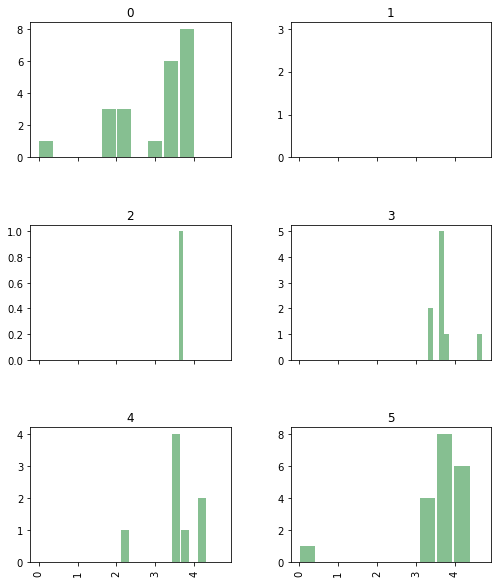

In [47]:
from matplotlib.ticker import StrMethodFormatter
ax = grouped.hist(column='Ratings_out_of_5', by='Cluster Labels', 
                  bins=10, grid=False, figsize=(8,10), layout=(3,2), 
                  sharex=True, color='#86bf91', zorder=2, rwidth=0.9)

array([[<AxesSubplot:title={'center':'Ratings_out_of_5'}>,
        <AxesSubplot:title={'center':'Number of votes'}>]], dtype=object)

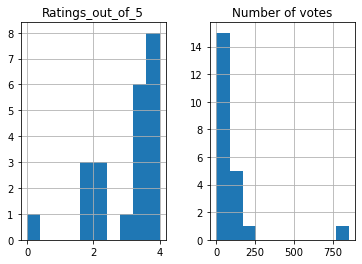

In [39]:
zero[['Ratings_out_of_5','Number of votes']].hist(bins=10)

array([[<AxesSubplot:title={'center':'Ratings_out_of_5'}>,
        <AxesSubplot:title={'center':'Number of votes'}>]], dtype=object)

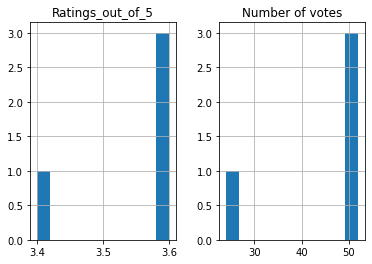

In [30]:
one[['Ratings_out_of_5','Number of votes']].hist(bins=10)

array([[<AxesSubplot:title={'center':'Ratings_out_of_5'}>,
        <AxesSubplot:title={'center':'Number of votes'}>]], dtype=object)

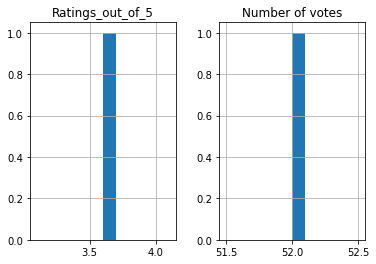

In [31]:
two[['Ratings_out_of_5','Number of votes']].hist(bins=10)

array([[<AxesSubplot:title={'center':'Ratings_out_of_5'}>,
        <AxesSubplot:title={'center':'Number of votes'}>]], dtype=object)

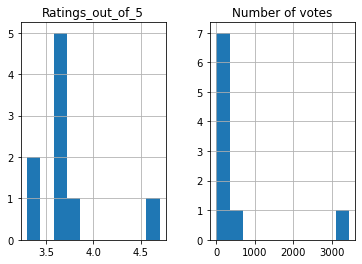

In [32]:
three[['Ratings_out_of_5','Number of votes']].hist(bins=10)

array([[<AxesSubplot:title={'center':'Ratings_out_of_5'}>,
        <AxesSubplot:title={'center':'Number of votes'}>]], dtype=object)

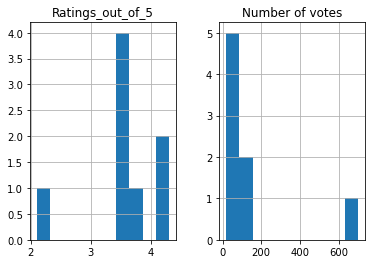

In [33]:
four[['Ratings_out_of_5','Number of votes']].hist(bins=10)

array([[<AxesSubplot:title={'center':'Ratings_out_of_5'}>,
        <AxesSubplot:title={'center':'Number of votes'}>]], dtype=object)

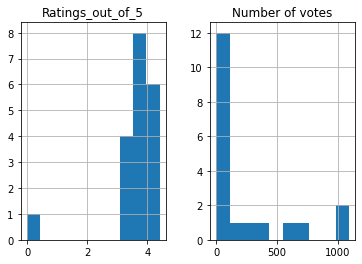

In [38]:
five[['Ratings_out_of_5','Number of votes']].hist(bins=10)